## Loading/Importing

### Import libraries

In [1]:
''' Import libraries '''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from mlxtend.evaluate import bias_variance_decomp

### Load and scale data

In [2]:
''' Load data '''
file_path = "/Users/bryanmcelvy/Documents/datasets/Heart_Disease_Prediction.csv" # Make sure to change this
df_all = pd.read_csv(file_path).drop(["index"], axis=1)
df = df_all.drop("Heart Disease", axis=1) # DataFrame containing the dataset without the target variable

''' Drop removed feature (FBS over 120) from data '''
df.drop([df.columns[5]], axis=1, inplace=True)
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,70,1,4,130,322,2,109,0,2.4,2,3,3
1,67,0,3,115,564,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,105,1,0.2,2,1,7
4,74,0,2,120,269,2,121,1,0.2,1,1,3


In [3]:
s_target = df_all["Heart Disease"]       # DataFrame containing only the target variable
labels = {0: "Absence", 1: "Presence"}
s_target.head()

0    Presence
1     Absence
2    Presence
3     Absence
4     Absence
Name: Heart Disease, dtype: object

In [4]:
X = df.to_numpy()
y = np.array([1 if (s_target.iloc[i] == labels[1]) else 0 for i in range(len(s_target))])

''' Scale data '''
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

''' Split into training and test sets '''
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# K-Nearest Neighbors (KNN) Classifier

## Hyperparameter Tuning

In [47]:
knn_params = {"n_neighbors": np.arange(1, 20, dtype=int),
            "weights": ['uniform', 'distance'],
            "algorithm": ['ball_tree', 'kd_tree', 'brute'],
            "p": np.arange(1, 10, dtype=int)}
knn = KNeighborsClassifier()

In [48]:
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, verbose=1)
knn_grid_search_result = knn_grid_search.fit(X_train, y_train)
print("Best Parameters:", knn_grid_search_result.best_params_)

Fitting 5 folds for each of 1026 candidates, totalling 5130 fits
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}


In [49]:
knn_algo = knn_grid_search_result.best_params_['algorithm']
k = knn_grid_search_result.best_params_['n_neighbors']
knn_weights = knn_grid_search_result.best_params_['weights']
knn_p = knn_grid_search_result.best_params_['p']

knn = KNeighborsClassifier(n_neighbors=k, algorithm=knn_algo, weights=knn_weights, p=knn_p)
knn.fit(X_train, y_train);

## Cross-validation

In [68]:
knn_cv_score = cross_val_score(knn, X_test, y_test, scoring='accuracy')
print("Cross-Validation Scores")
print(f"\tAccuracy:\t{knn_cv_score}\n\tAvg. Accuracy:\t{np.mean(knn_cv_score)}\n\tSt. Dev:\t{np.std(knn_cv_score)}")

Cross-Validation Scores
	Accuracy:	[0.92857143 0.92857143 0.78571429 0.92307692 0.76923077]
	Avg. Accuracy:	0.867032967032967
	St. Dev:	0.07333878555368609


## Performance Evaluation

In [51]:
y_pred_knn = knn.predict(X_test)

### F-Score

In [52]:
print(classification_report(y_test, y_pred_knn, labels=list(labels.keys()), target_names=[labels[0], labels[1]]))

              precision    recall  f1-score   support

     Absence       0.87      1.00      0.93        40
    Presence       1.00      0.79      0.88        28

    accuracy                           0.91        68
   macro avg       0.93      0.89      0.91        68
weighted avg       0.92      0.91      0.91        68



### Bias-Variance Tradeoff

In [53]:
knn_expected_loss, knn_avg_bias, knn_avg_var = bias_variance_decomp(
    knn, X_train, y_train, X_test, y_test, random_seed=42)
print(f"Expected Loss: {knn_expected_loss}\nAvg. Bias: {knn_avg_bias}\nAvg. Variance: {knn_avg_var}")

Expected Loss: 0.13573529411764707
Avg. Bias: 0.10294117647058823
Avg. Variance: 0.06411764705882352


### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix for K-Nearest Neighbors Classifier')

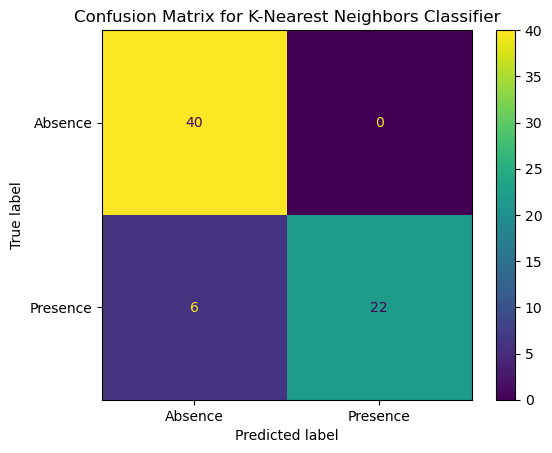

In [72]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, 
    labels=list(labels.keys()), display_labels=[labels[0], labels[1]])
plt.title("Confusion Matrix for K-Nearest Neighbors Classifier")

### ROC Curve

In [55]:
FP_rate_knn, TP_rate_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
AUC_knn = roc_auc_score(y_test, y_pred_knn)
print(f"Area under ROC Curve (AUC): {AUC_knn}")

Area under ROC Curve (AUC): 0.8928571428571428


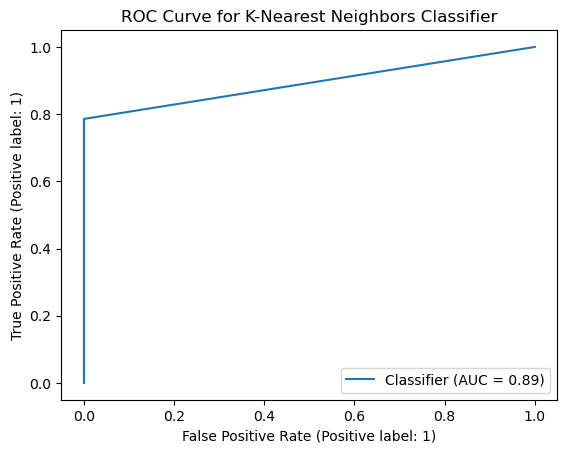

In [56]:
RocCurveDisplay.from_predictions(y_test, y_pred_knn)
plt.title("ROC Curve for K-Nearest Neighbors Classifier");

# Logistic Regression Classifier

## Hyperparameter Tuning

In [57]:
log_reg_params = {"solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                    "C": np.linspace(0.1, 1.0, 10, dtype=float),
                    "fit_intercept": [True, False],
                    "max_iter": np.linspace(100, 1000, 10, dtype=int)}

log_reg = LogisticRegression()

In [58]:
log_reg_grid_search = GridSearchCV(estimator=log_reg, param_grid=log_reg_params, verbose=1)
log_reg_grid_search_result = log_reg_grid_search.fit(X_train, y_train)
print("Best Parameters:", log_reg_grid_search_result.best_params_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Parameters: {'C': 0.1, 'fit_intercept': True, 'max_iter': 100, 'solver': 'liblinear'}


In [59]:
log_reg_C = log_reg_grid_search_result.best_params_['C']
log_reg_fit_intercept = log_reg_grid_search_result.best_params_['fit_intercept']
log_reg_max_iter = log_reg_grid_search_result.best_params_['max_iter']
log_reg_solver = log_reg_grid_search_result.best_params_['solver']

log_reg = LogisticRegression(C=log_reg_C, fit_intercept=log_reg_fit_intercept,
                                max_iter=log_reg_max_iter, solver=log_reg_solver)
log_reg.fit(X_train, y_train);

## Cross-validation

In [69]:
log_reg_cv_score = cross_val_score(log_reg, X_test, y_test, scoring='accuracy')

print("Cross-Validation Scores")
print(f"\tAccuracy:\t{log_reg_cv_score}\n\tAvg. Accuracy:\t{np.mean(log_reg_cv_score)}\n\tSt. Dev:\t{np.std(log_reg_cv_score)}")

Cross-Validation Scores
	Accuracy:	[1.         0.92857143 0.78571429 0.92307692 0.84615385]
	Avg. Accuracy:	0.8967032967032967
	St. Dev:	0.07383110783402562


## Performance Evaluation

In [61]:
y_pred_log_reg = log_reg.predict(X_test)

### F-Score

In [62]:
print(classification_report(y_test, y_pred_log_reg, labels=list(labels.keys()), target_names=[labels[0], labels[1]]))

              precision    recall  f1-score   support

     Absence       0.88      0.93      0.90        40
    Presence       0.88      0.82      0.85        28

    accuracy                           0.88        68
   macro avg       0.88      0.87      0.88        68
weighted avg       0.88      0.88      0.88        68



### Bias-Variance Tradeoff

In [63]:
log_reg_expected_loss, log_reg_avg_bias, log_reg_avg_var = bias_variance_decomp(
    log_reg, X_train, y_train, X_test, y_test, random_seed=42)
print(f"Expected Loss:\t{log_reg_expected_loss}\nAvg. Bias:\t{log_reg_avg_bias}\nAvg. Variance:\t{log_reg_avg_var}")

Expected Loss:	0.13860294117647057
Avg. Bias:	0.1323529411764706
Avg. Variance:	0.06066176470588234


### Confusion Matrix

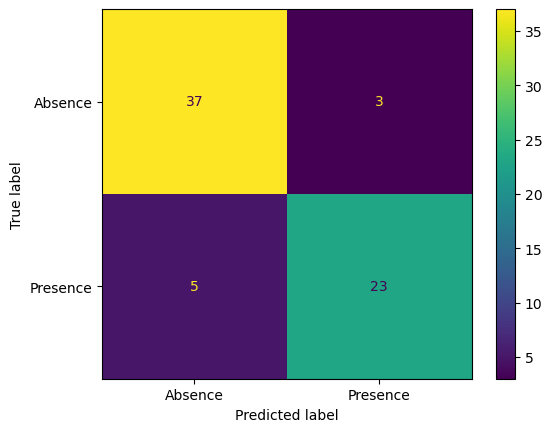

In [64]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log_reg, 
    labels=list(labels.keys()), display_labels=[labels[0], labels[1]])

### ROC Curve

In [65]:
FP_rate_log_reg, TP_rate_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)
AUC_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print(f"Area under ROC Curve (AUC): {AUC_log_reg}")

Area under ROC Curve (AUC): 0.8732142857142857


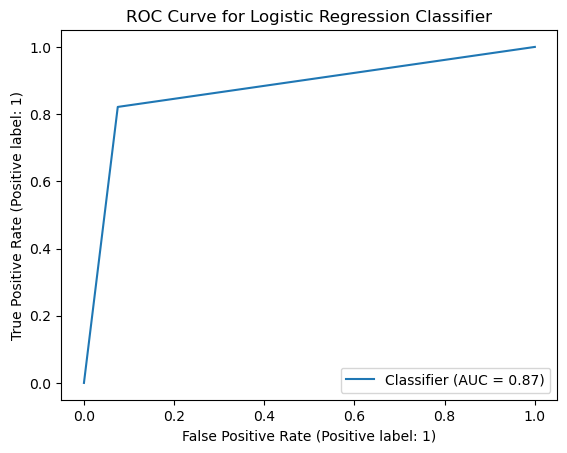

In [66]:
RocCurveDisplay.from_predictions(y_test, y_pred_log_reg)
plt.title("ROC Curve for Logistic Regression Classifier");